# Cервис аренды самокатов GoFast

**У нас есть данные о некоторых пользователях из нескольких городов, а также об их поездках. Мы проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.**


**Есть 2 категории людей, которые пользуются сервисом GoFast пользуются в мобильным приложением:**
    
    без подписки
        абонентская плата отсутствует;
        стоимость одной минуты поездки — 8 рублей;
        стоимость старта (начала поездки) — 50 рублей;

    с подпиской Ultra
        абонентская плата — 199 рублей в месяц;
        стоимость одной минуты поездки — 6 рублей;
        стоимость старта — бесплатно.
        
Наши цели,это проверить гипотезы:
1. Тратят ли пользователи с подпиской больше времени на поездки? 
2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 
3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
4. Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Снизилось ли количество обращений в техподдержку значимо снизилось из-за обновления?


Ход исследования.

Данные о поведении пользователей мы получили из файлов /datasets/users_go.csv, /datasets/rides_go.csv, /datasets/subscriptions_go.csv. О качестве данных ничего не известно. Поэтому перед проверкой гипотез понадобится обзор данных.

Мы проверим данные на ошибки и оценим их влияние на исследование.

Таким образом, исследование пройдёт в три этапа:

    Обзор данных.
    Предобработка данных.
    Проверка гипотез.

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import binom, poisson, norm
from math import sqrt

#### Шаг 1. Загрузка данных

1.1 Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраните их в датафреймы. 
    
1.2 Выведем первые строки каждого набора данных. Изучим общую информацию о каждом датафрейме.

In [108]:
datausers = pd.read_csv('users_go.csv')
datarides = pd.read_csv('rides_go.csv')
datasubscriptions = pd.read_csv('subscriptions_go.csv')


In [109]:
datausers.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [110]:
datarides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [111]:
datasubscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [112]:
datausers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [113]:
datarides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [114]:
datasubscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Описание данных


В основных данных есть информация о пользователях, их поездках и подписках.

* Пользователи — users_go.csv - datausers
    - user_id - уникальный идентификатор пользователя
    - name - имя пользователя
    - age - возраст
    - city - город
    - subscription_type - тип подписки (free, ultra)
        
* Поездки — rides_go.csv - datarides
    - user_id	- уникальный идентификатор пользователя
    - distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
    - duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
    - date - дата совершения поездки
        
* Подписки — subscriptions_go.csv - datasubscriptions
    - subscription_type - тип подписки
    - minute_price - стоимость одной минуты поездки по данной подписке
    - start_ride_price - стоимость начала поездки
    - subscription_fee - стоимость ежемесячного платежа

**Вывод:** в таблицах — данные о о пользователях, их поездках и подписках. Пропусков в данных нет. Думаю данных достаточно для проверки гипотез. Чтобы двигаться дальше проверим данные на аномалии.

#### Шаг 2. Предобработка данных

2.1 Приведем столбец date в таблице datarides к типу даты pandas.

In [115]:
datarides['date'] = pd.to_datetime(datarides['date'], format='%Y-%m-%d')
datarides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


2.2 Создадим новый столбец datemonth в таблице datarides с номером месяца на основе столбца date.

In [116]:
datarides['datemonth'] = pd.DatetimeIndex(datarides['date']).month
datarides['datemonth']

0         1
1         1
2         4
3         8
4         8
         ..
18063    11
18064    11
18065    11
18066    11
18067    12
Name: datemonth, Length: 18068, dtype: int64

2.3 Проверим наличие дубликатов в датафреймах. Обработаем их, если такие значения присутствуют.

In [117]:
datausers.duplicated().sum()

31

Явных дубликатов в таблице datausers по пользователям 31. Удалим их с помощью метода drop_duplicates.

In [118]:
datausers = datausers.drop_duplicates()

Проверим наличие явных дубликатов после удаления.

In [119]:
datausers.duplicated().sum()

0

Дубликаты удалились, проделаем тоже самое по оставшимся 2 таблицам: datarides и datasubscriptions

In [120]:
datarides.duplicated().sum()

0

В таблице о поездках дубликатов нет.

In [121]:
datasubscriptions.duplicated().sum()

0

В таблице о подписках дубликатов нет.

Теперь проверим столбцы age,city,subscription_type,distance на неявные дубликаты и аномалии.

In [122]:
datausers['age'].unique()

array([22, 31, 20, 26, 28, 25, 23, 21, 18, 27, 24, 29, 32, 14, 19, 30, 17,
       12, 35, 33, 13, 15, 37, 16, 34, 38, 36, 39, 43], dtype=int64)

В столбце age выбивающихся значений нет.

In [123]:
datausers['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

В столбце city неявных дубликатов нет.

In [124]:
datausers['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

В столбце subscription_type неявных дубликатов нет.

In [125]:
datarides['distance'].unique()

array([4409.9191402 , 2617.59215346,  754.15980696, ..., 3826.1855073 ,
       2902.30866066, 2371.71119224])

В столбце distance слишком много уникальных значений, поэтому построим гистограмму,что вычислить если выбивающиеся значения.

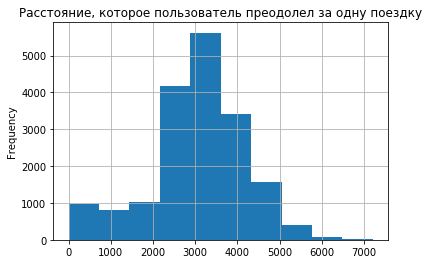

In [126]:
datarides['distance'].plot(kind='hist', bins = 10, title="Расстояние, которое пользователь преодолел за одну поездку", xlabel = 'Расстояние', ylabel= 'количество людей', grid = True)
plt.show()

In [127]:
datarides['user_id'].unique()

array([   1,    2,    3, ..., 1532, 1533, 1534], dtype=int64)

In [128]:
datarides['user_id'].nunique()

1534

In [129]:
datarides['user_id'].count()

18068

In [130]:
datausers['user_id'].unique()

array([   1,    2,    3, ..., 1532, 1533, 1534], dtype=int64)

In [131]:
datausers['user_id'].nunique()

1534

In [132]:
datausers['user_id'].count()

1534

В столбце user_id в таблицах datarides и datausers нет выбивающихся значений. И судя по тому,что количство уникальных значений совпадает и начало и конец уникальных значений тоже совпадает, можно будет объединить таблицы datausers и datarides по столбцу user_id в следующих шагах.

Вывод.

Мы привели столбец date в таблице datarides к типу даты pandas.

Мы обнаружили 31 явный дубликат в таблице datausers по пользователям и удалили их с помощью метода drop_duplicates. 

Мы создали новый столбец datemonth в таблице datarides с номером месяца на основе столбца date.

Неявные дубликаты мы не обнаружили. Обнаружили, столбцы user_id в таблицах datausers и datarides по уникальным значениям совпадают, значит по ним можно будет соединять 2 таблицы.

В эксперименте участвуют 8 городов, 1534 человека.

#### Шаг 3. Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках.

    3.1 частота встречаемости городов;
    3.2 соотношение пользователей с подпиской и без подписки;
    3.3 возраст пользователей;
    3.4 расстояние, которое пользователь преодолел за одну поездку;
    3.5 продолжительность поездок.

In [133]:
datausers

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1529,1530,Ростислав,29,Сочи,free
1530,1531,Никита,25,Пятигорск,free
1531,1532,Алексей,26,Тюмень,free
1532,1533,Степан,22,Краснодар,free


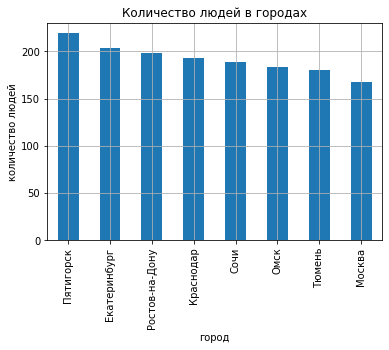

In [134]:
datausers['city'].value_counts().plot(kind='bar', title="Количество людей в городах", xlabel = 'город', ylabel= 'количество людей', grid = True)
plt.show()

Чаще всего встречается Пятигорск, более 200 человек, меньше всего Москва, 175 примерно.

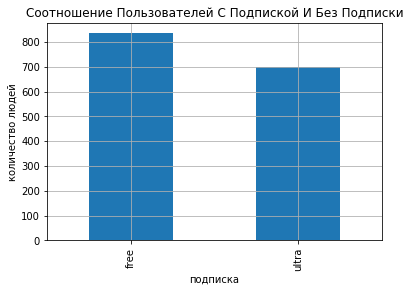

In [135]:
datausers['subscription_type'].value_counts().plot(kind='bar', title="Соотношение Пользователей С Подпиской И Без Подписки", xlabel = 'подписка', ylabel= 'количество людей', grid = True)
plt.show()

Больше всего людей без подписки.

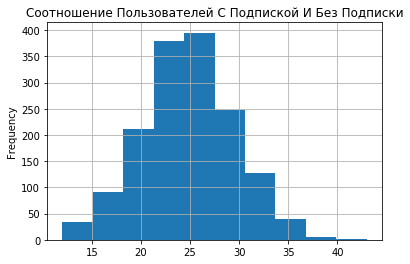

In [136]:
datausers['age'].plot(kind='hist', title="Соотношение Пользователей С Подпиской И Без Подписки", xlabel = 'возраст пользователей', ylabel= 'количество людей', grid = True)
plt.show()

In [137]:
datausers['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Самый популярный возраст пользователей от 24 до 28. Меньше всего от 35 до 40. Учитывая, что в правилах проката электросамокатов запрещена аренда детьми до 18 лет, то странно видеть тут пользователей  свозрастом меньше 18.

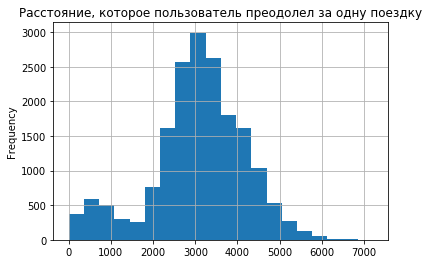

In [138]:
datarides['distance'].plot(kind='hist', bins = 20, title="Расстояние, которое пользователь преодолел за одну поездку", xlabel = 'Расстояние', ylabel= 'количество людей', grid = True)
plt.show()

От 2.9 км до 3.5  км самое частое расстояние. Редко встречаются преодоленные расстояния свыше 6 км. Виден еще набольшой пик на ~600м и затем снижение, воможно это связано с тарифами на поездки, например, первые 6 минут дешевле, поэтому все стараются в них уложиться и проезжают 600м. Либо это самое расспространенное расстояние от парковки самокатов у метро до мест работы многих пользователей.

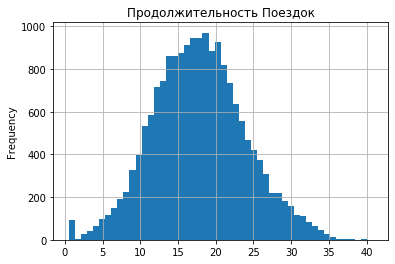

In [139]:
datarides['duration'].plot(kind='hist', bins = 50, title="Продолжительность Поездок", xlabel = 'Продолжительность Поездок', ylabel= 'количество людей', grid = True)
plt.show()

Чаще всего поездки от 16 до 21 минуты. Редко от 35 до 40 минут. Видно, что есть пик на графике на уровне ~1 минуты. Вероятно, это связано со сбоем геолокации.

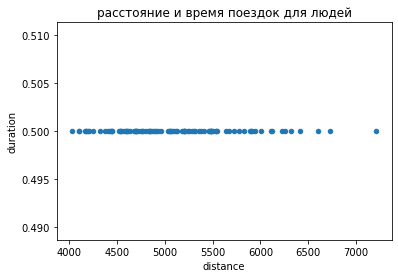

In [140]:
datarides[datarides['duration'] < 2].plot(x='distance', y='duration', kind='scatter', title = 'расстояние и время поездок для людей')
plt.show()

Вряд ли кто-то мог ехать со скоростью ~250км/ч, так что это больше похоже на аномалию: сбой времени при логировании или геолокации.

Вывод.

Чаще всего пользователи встречаются из Пятигорска (более 200 человек),без подписки, возраст от 24 до 28, проезжают от 2.9 км до 3.5 км за 16-21 минуту. Реже всего пользователи встречаются из Москвы с подпиской в возрасте от 35 до 40, с преодоленным расстоянием свыше 6 км, со временем использования 35-40 минут.

#### Шаг 4. Объединение данных

4.1 Объединим данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйемся методом merge().

Используем метод inner, так как нас интересуют только пользователи, которые совершали поездки, и есть данные о пользователях, где указаны имя ,подписка и т.д. Этот метод отбрасывает строки с нулевыми значениями.

In [141]:
data=datausers.merge(datarides, on = 'user_id', how = 'inner')
data

,user_id,name,age,city,subscription_type,distance,duration,date,datemonth
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11


Получилось 18068 строк, как и в таблице datarides, следовательно мы ни одни данные не отбросили. Проверим таблицу на наличие пропусков.

In [142]:
data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
datemonth            0
dtype: int64

Пропусков нет.

4.2 Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1:

    c данными о пользователях без подписки;
    с данными о пользователях с подпиской.
    

In [143]:
dataultra = data[data['subscription_type']=='ultra']
dataultra

,user_id,name,age,city,subscription_type,distance,duration,date,datemonth
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10


In [144]:
datafree = data[data['subscription_type']=='free']
datafree

,user_id,name,age,city,subscription_type,distance,duration,date,datemonth
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2
...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11


Поездок без подписки 11 568, поездок с подпиской 6 500.

4.3 Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

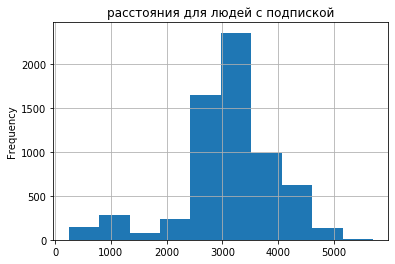

In [145]:
dataultra['distance'].plot(kind='hist', bins = 10, title="расстояния для людей с подпиской", xlabel = 'Расстояние', ylabel= 'количество людей', grid = True)
plt.show()

Люди с подпиской чаще всего преодолеват 3-3,5 км. за поездку.

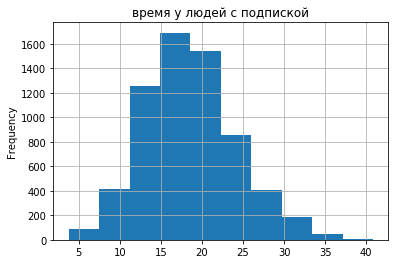

In [146]:
dataultra['duration'].plot(kind='hist', bins = 10, title="время у людей с подпиской", xlabel = 'время', ylabel= 'количество людей', grid = True)
plt.show()

Люди сподпиской чаще всего ездят по 15-20минут.

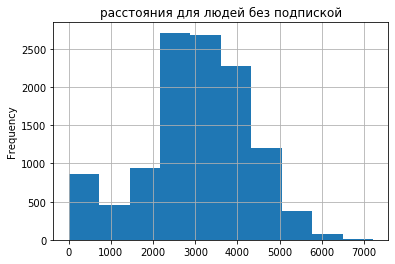

In [147]:
datafree['distance'].plot(kind='hist', bins = 10, title="расстояния для людей без подпиской", xlabel = 'расстояние', ylabel= 'количество людей', grid = True)
plt.show()

Люди без подписки чаще всего ездят 2,1-3,5км.Так же мы видим выброс, увеличенный от 0 до 0,5км - скорей всего это сбой геолокации.

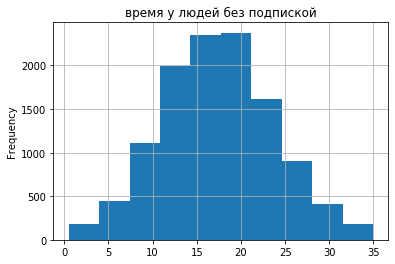

In [148]:
datafree['duration'].plot(kind='hist', bins = 10, title="время у людей без подпиской", xlabel = 'время', ylabel= 'количество людей', grid = True)
plt.show()

Время у людей без подписки чаще всего тратится 14-22 минуты.

Вывод.

Поездок без подписок больше их 11 568, они проезжают расстояния  2,1-3,5км.,время тратят 14-22 минуты.

Поездок с подпиской меньше 6 500, расстояния 3-3,5 км., время 15-20 минут.

На первы взшляд, один человек с подпиской, больше приносит прибыли компании,чем без подписки. Но так как людей без подписок больше, то нельзя однозначно утверждать,  какакя категория суммарно приносит больше денег компании.

#### Шаг 5. Подсчёт выручки

5.1 Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [149]:
data_revenue= pd.pivot_table(data, values=['distance', 'duration'],
                             index=['user_id', 'datemonth'], 
                             aggfunc={'distance': "sum", 'duration': ["sum", "count"]}).reset_index()
data_revenue.columns = ['user_id', 'datemonth', 'distance', 'duration_count', 'duration']
data_revenue['duration'] = np.ceil(data_revenue['duration'])
data_revenue['distance'] = data_revenue['distance'].round(2)
data_revenue

,user_id,datemonth,distance,duration_count,duration
0,1,1,7027.51,2,42.0
1,1,4,754.16,1,7.0
2,1,8,6723.47,2,45.0
3,1,10,5809.91,2,32.0
4,1,11,7003.50,3,54.0
...,...,...,...,...,...
11326,1534,6,3409.47,2,25.0
11327,1534,8,7622.45,2,48.0
11328,1534,9,4928.17,1,23.0
11329,1534,11,13350.02,4,77.0


5.2 В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округлим до следующего целого числа

In [150]:
def method_revenue(data_revenue):
    if data_revenue['user_id'] in datafree['user_id'].values:
        return (data_revenue['duration_count'] * datasubscriptions.loc[0, 'start_ride_price'] 
                + data_revenue['duration']*datasubscriptions.loc[0, 'minute_price'] 
                + datasubscriptions.loc[0, 'subscription_fee'])
    if data_revenue['user_id'] in dataultra['user_id'].values:
        return (data_revenue['duration_count'] * datasubscriptions.loc[1, 'start_ride_price'] 
                + data_revenue['duration']*datasubscriptions.loc[1, 'minute_price'] 
                + datasubscriptions.loc[1, 'subscription_fee'])

In [151]:
data_revenue['revenue'] = data_revenue.apply(method_revenue, axis =1)
data_revenue

,user_id,datemonth,distance,duration_count,duration,revenue
0,1,1,7027.51,2,42.0,451.0
1,1,4,754.16,1,7.0,241.0
2,1,8,6723.47,2,45.0,469.0
3,1,10,5809.91,2,32.0,391.0
4,1,11,7003.50,3,54.0,523.0
...,...,...,...,...,...,...
11326,1534,6,3409.47,2,25.0,300.0
11327,1534,8,7622.45,2,48.0,484.0
11328,1534,9,4928.17,1,23.0,234.0
11329,1534,11,13350.02,4,77.0,816.0


Вывод: мы подготовили отличные данные, чтобы проверить гипотезы об увеличении выручки.

#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Нулевая гипотеза: пользователи с подпиской тратят больше времени на поездки.

Альернативная гипотеза: пользователи с подпиской не тратят больше времени на поездки.

In [152]:
alpha = 0.05 # уровень статистической значимости


results = st.ttest_ind(dataultra['duration'], datafree['duration'], alternative='greater', equal_var = False)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue > alpha:
    print('Отвергаем нулевую гипотезу. Пользователи с подпиской не тратят больше времени на поездки.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу.Пользователи с подпиской тратят больше времени на поездки.')

p-value: 5.675781377128977e-37
Нет оснований отвергнуть нулевую гипотезу.Пользователи с подпиской тратят больше времени на поездки.


6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим гипотезу и сделаем выводы.

Нулевая гипотеза: пользователи с подпиской проезжают  за одну поездку, больше 3130 метров.

Альернативная гипотеза: пользователи с подпиской проезжают  за одну поездку,не больше 3130 метров.

In [153]:
interested_value = 3130 # оптимальное расстояние одной поездки

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    dataultra['distance'], 
    interested_value,
      alternative='less') 

print('p-значение:', results.pvalue)

if results.pvalue>alpha:
    print('Отвергаем нулевую гипотезу:пользователи с подпиской проезжают  за одну поездку,не больше 3130 метров.')
else:
    print('Не получилось отвергнуть нулевую гипотезу:пользователи с подпиской проезжают  за одну поездку, больше 3130 метров.')

p-значение: 0.08046311521502145
Отвергаем нулевую гипотезу:пользователи с подпиской проезжают  за одну поездку,не больше 3130 метров.


6.3. Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Подготовим 2 таблицы с подпиской и без, с указанием выручки по месяцам.

In [154]:
def method_revenue_month_free(data_revenue):
    if data_revenue['user_id'] in datafree['user_id'].values:
        return data_revenue['revenue']

In [155]:
revenue_month_free=data_revenue.apply(method_revenue_month_free, axis =1)
revenue_month_free = revenue_month_free.dropna()
revenue_month_free

4533     170.0
4534     938.0
4535     202.0
4536     178.0
4537     332.0
         ...  
11326    300.0
11327    484.0
11328    234.0
11329    816.0
11330    178.0
Length: 6798, dtype: float64

In [156]:
def method_revenue_month_ultra(data_revenue):
    if data_revenue['user_id'] in dataultra['user_id'].values:
        return data_revenue['revenue']

In [157]:
revenue_month_ultra=data_revenue.apply(method_revenue_month_ultra, axis =1)
revenue_month_ultra = revenue_month_ultra.dropna()
revenue_month_ultra

0       451.0
1       241.0
2       469.0
3       391.0
4       523.0
        ...  
4528    301.0
4529    469.0
4530    385.0
4531    295.0
4532    355.0
Length: 4533, dtype: float64

Нулевая гипотеза: помесячная выручка от пользователей с подпиской по месяцам выше.

Альернативная гипотеза: помесячная выручка от пользователей с подпиской по месяцам выше.

In [159]:
alpha = 0.05 # уровень статистической значимости


results = st.ttest_ind(revenue_month_ultra, revenue_month_free, alternative='greater', equal_var = False)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue > alpha:
    print('Отвергаем нулевую гипотезу. Помесячная выручка от пользователей с подпиской по месяцам не выше.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу.Помесячная выручка от пользователей с подпиской по месяцам выше.')
    
print(f'Средняя помесячная выручка от пользователей с подпиской {round(revenue_month_ultra.mean(), 2)}.')
print(f'Средняя помесячная выручка от пользователей без подписки {round(revenue_month_free.mean(), 2)}.')

p-value: 1.0718729651261336e-44
Нет оснований отвергнуть нулевую гипотезу.Помесячная выручка от пользователей с подпиской по месяцам выше.
Средняя помесячная выручка от пользователей с подпиской 361.48.
Средняя помесячная выручка от пользователей без подписки 325.84.


In [160]:
alpha = 0.05 # уровень статистической значимости


results = st.ttest_ind(revenue_month_ultra, revenue_month_free, alternative='greater', equal_var = False)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue > alpha:
    print('Отвергаем нулевую гипотезу. Помесячная выручка от пользователей с подпиской по месяцам не выше.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу.Помесячная выручка от пользователей с подпиской по месяцам выше.')
    
print(f'Средняя помесячная выручка от пользователей с подпиской {round(revenue_month_ultra.mean(), 2)}.')
print(f'Средняя помесячная выручка от пользователей без подписки {round(revenue_month_free.mean(), 2)}.')

p-value: 1.0718729651261336e-44
Нет оснований отвергнуть нулевую гипотезу.Помесячная выручка от пользователей с подпиской по месяцам выше.
Средняя помесячная выручка от пользователей с подпиской 361.48.
Средняя помесячная выручка от пользователей без подписки 325.84.


6.4. Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест нам понадобился бы для проверки этой гипотезы?

Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, применим метод scipy.stats.ttest_rel().
Ему достаточно передать всего два параметра: наборы данных до и после. Оба набора должны быть одинаковыми по размеру: каждое измерение должно быть проведено до и после изменения.
Подразумевается, что порядок объектов, для которых сделаны измерения, в обоих массивах тоже одинаковый: 
k-е число во втором наборе — это измерения для одного и того же объекта до и после изменения. Тест будет односторонним.

Вывод. Пользователи с подпиской тратят больше времени на поездки, проезжают  за одну поездку,не больше 3130 метров, и помесячная выручка по месяцам выше.Продакт-менеджерам сервиса можно увеличивать количество пользователей с подпиской.

#### Шаг 7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясним, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберем параметры распределения, описывающего эту ситуацию, построем график распределения и сформулируем ответ на вопрос о количестве промокодов.

Количество промокодов, которое нужно раздать 1161


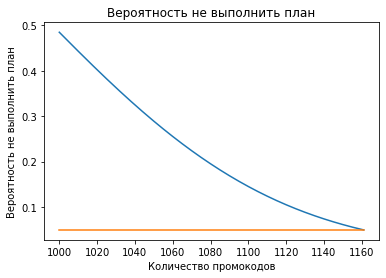

In [161]:
# вероятность продлить подписку
p = 0.1
k=99

n = [1000]
cdfs = [st.binom.cdf(k,n[-1],p)]
while cdfs[-1] >= 0.05:
    n.append(n[-1]+1) 
    cdfs.append(st.binom.cdf(k,n[-1],p))
    
print('Количество промокодов, которое нужно раздать', n[-1])

plt.plot(n,cdfs)
plt.plot(n, [0.05 for i in range(len(n))])
plt.title('Вероятность не выполнить план')
plt.xlabel('Количество промокодов')
plt.ylabel('Вероятность не выполнить план')
plt.show()

7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Поскольку вероятность открытия уведомления близка к 0.5, а количество разосланных уведомлений досточно большое - 1 млн, то скорее всего можно аппроксимировать биномиальное распределение нормальным. Проверим.

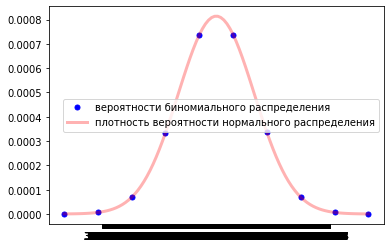

<Figure size 1440x864 with 0 Axes>

Условие выполняется


In [162]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = np.linspace(max(0,left),right,10, dtype= int)
# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5,
      label='вероятности биномиального распределения')

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
 
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = np.linspace(left,right,100, dtype= int)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3, label='плотность вероятности нормального распределения')
 
# зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
# (последний аргумент в методе range - интервал между подписями)
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1))
ax.set_xticks(x_ticks)

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.figure(figsize=(20,12))
plt.show()

# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')

In [163]:
# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma)

# считаем вероятность хвоста слева от 399,5 тыс. 
result = distr.cdf(399500)
print(f'Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей {(result*100).round(2)}%.')



Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей 15.37%.


#### Общий вывод.


Исследование о сервисе аренды самокатов GoFast началось с предобработки данных.

Мы проверили и исправили соотвествие типов каждому столбцу, формат даты перевели из object в datetime, удалили явные дубликаты .Пропусков и явных дубликатов в данных не обнаружили.

В таблице данные об 8 городах и 1534 людей.

Чаще всего в данных встречались пользователи из Пятигорска (более 200 человек),без подписки,в возрасте от 24 до 28, проезжающие от 2.9 км до 3.5 км за 16-21 минуту. Реже всего встречались пользователи из Москвы с подпиской в возрасте от 35 до 40, с преодоленным расстоянием свыше 6 км, со временем использования 35-40 минут.

Поездок без подписок больше их 11 568, они проезжают расстояния  2,1-3,5км.,время тратят 14-22 минуты.

Поездок с подпиской меньше 6 500, расстояния 3-3,5 км., время 15-20 минут.

 Пользователи с подпиской тратят больше времени на поездки, проезжают за одну поездку,не больше 3130 метров, и помесячная выручка по месяцам выше.Продакт-менеджерам сервиса можно увеличивать количество пользователей с подпиской.
 
Рекомендация по улучшению сбора данных и системы скоринга столбец с датой собирать в типе datetime;